In [1]:
# Import the necessary packages
from utils.simplecnn import SimpleCNN
from utils.datagen import generate_mixed_adversarial_batch
from utils.datagen import generate_adversarial_batch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from utils.cifar_10 import load_data
import numpy as np
from copy import deepcopy
from PIL import Image, ImageOps, ImageDraw, ImageFont
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify font to draw on images
font = ImageFont.truetype("utils/arial.ttf", 9)

In [3]:
# Load the CIFAR-10 dataset. If server is down (error 503), follow the big comment below.
# If facing certificate error, follow this: https://stackoverflow.com/questions/69687794/unable-to-manually-load-cifar10-dataset

# Download/Get the Python3-compatible CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz or anywhere else.
# Make sure tar.gz file is fully unzipped and in the same location as this .py file.
# Use "tar -zxvf cifar-10-python.tar.gz" command to completely unzip the CIFAR-10 dataset to get a directory
# named "cifar-10-batches-py" in the same location as this current .py file. 
print("[INFO] Loading CIFAR-10 dataset...")
# (trainX, trainY), (testX, testY) = cifar10.load_data()
(trainX, trainY), (testX, testY) = load_data()

[INFO] Loading CIFAR-10 dataset...


In [4]:
# Scale the pixel values to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

In [5]:
# Add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

In [6]:
# One-hot encode the labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [7]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [8]:
# Initialize the optimizer and model
print("[INFO] Compiling the model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Compiling the model...


2022-05-09 08:15:39.205871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 08:15:39.256353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 08:15:39.256803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 08:15:39.259152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 08:15:39.259601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

In [9]:
# Train the simple CNN on CIFAR-10
print("[INFO] Training the network...")
H1 = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=20, verbose=1)

[INFO] Training the network...
Epoch 1/20


2022-05-09 08:15:43.912401: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


782/782 [==============================] - 8s 7ms/step - loss: 1.6129 - accuracy: 0.4457 - val_loss: 1.3996 - val_accuracy: 0.5072
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 1.1667 - accuracy: 0.5879 - val_loss: 1.1186 - val_accuracy: 0.5964
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 1.0031 - accuracy: 0.6465 - val_loss: 1.0539 - val_accuracy: 0.6288
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.9108 - accuracy: 0.6801 - val_loss: 1.0004 - val_accuracy: 0.6473
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.8323 - accuracy: 0.7082 - val_loss: 0.9728 - val_accuracy: 0.6587
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.7607 - accuracy: 0.7314 - val_loss: 0.9709 - val_accuracy: 0.6679
Epoch 7/20
782/782 [==============================] - 5s 6ms/step - loss: 0.7051 - accuracy: 0.7504 - val_loss: 1.2670 - val_accuracy: 0.5802
Epoch 8/20
782/78

In [10]:
# Make predictions on the testing set for the model trained on non-adversarial images
(loss, accuracy) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] Normal testing images: ")
print("[INFO] Loss: {:.4f}, Accuracy: {:.4f}\n".format(loss, accuracy))

[INFO] Normal testing images: 
[INFO] Loss: 1.2139, Accuracy: 0.6767



In [11]:
# Predictions on non-adversarial images for classification report
print("[INFO] Evaluating network...")
predictions_normal = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions_normal.argmax(axis=1), target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

    airplane       0.69      0.75      0.72      1000
  automobile       0.84      0.72      0.78      1000
        bird       0.54      0.58      0.56      1000
         cat       0.49      0.47      0.48      1000
        deer       0.65      0.58      0.62      1000
         dog       0.56      0.62      0.59      1000
        frog       0.82      0.66      0.74      1000
       horse       0.72      0.76      0.74      1000
        ship       0.72      0.86      0.78      1000
       truck       0.77      0.76      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



In [12]:
# Generate a set of adversarial images from the test set (in order to evaluate the model performance
# *before* and *after* the mixed adversarial training)
print("[INFO] Generating adversarial examples with FGSM...\n")
(advX, advY) = next(generate_adversarial_batch(model, len(testX), testX, testY, (32, 32, 3), eps=0.01))

[INFO] Generating adversarial examples with FGSM...



In [13]:
# Re-evaluate the model on the adversarial images
(loss, accuracy) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] Adversarial testing images:")
print("[INFO] Loss: {:.4f}, Accuracy: {:.4f}\n".format(loss, accuracy))

[INFO] Adversarial testing images:
[INFO] Loss: 8.1357, Accuracy: 0.0720



In [14]:
# Predictions on adversarial images for classification report
print("[INFO] Evaluating network...")
predictions_adv = model.predict(advX, batch_size=32)
print(classification_report(advY.argmax(axis=1), predictions_adv.argmax(axis=1), target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

    airplane       0.12      0.15      0.13      1000
  automobile       0.09      0.06      0.08      1000
        bird       0.02      0.03      0.03      1000
         cat       0.00      0.01      0.00      1000
        deer       0.01      0.01      0.01      1000
         dog       0.03      0.03      0.03      1000
        frog       0.07      0.03      0.04      1000
       horse       0.12      0.10      0.11      1000
        ship       0.17      0.20      0.18      1000
       truck       0.12      0.11      0.11      1000

    accuracy                           0.07     10000
   macro avg       0.08      0.07      0.07     10000
weighted avg       0.08      0.07      0.07     10000



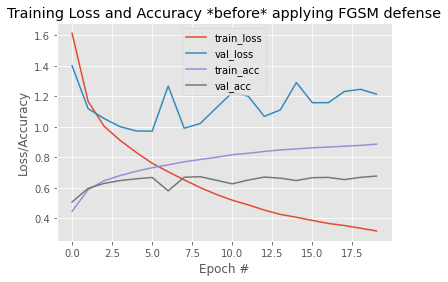

In [15]:
# plot the training loss and accuracy over time before applying defense
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy *before* applying FGSM defense")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## FGSM Defense

In [16]:
# Lower the learning rate and re-compile the model (in order to fine-tune the model on the mixed batches
# of normal images and the dynamically generated adversarial images)
print("[INFO] Re-compiling the model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Re-compiling the model...


In [17]:
# Initialize the data generator to create data batches containing a mix of both
# *normal* and *adversarial* images
print("[INFO] Creating the mixed data generator...")
dataGen = generate_mixed_adversarial_batch(model, 64, trainX, trainY, (32, 32, 3), eps=0.01, split=0.5)

[INFO] Creating the mixed data generator...


In [18]:
# Fine-tune the CNN on the adversarial images
print("[INFO] Fine-tuning the network in dynamic mixed data...")
# H2 = model.fit(dataGen, steps_per_epoch=len(trainX)//64, epochs=10, verbose=1)
# H2 = model.fit(dataGen, steps_per_epoch=len(trainX)//64, validation_data=(testX, testY), epochs=10, verbose=1)
H2 = model.fit(dataGen, steps_per_epoch=len(trainX)//64, validation_data=(advX, advY), epochs=10, verbose=1)

[INFO] Fine-tuning the network in dynamic mixed data...
Epoch 1/10
781/781 [==============================] - 321s 410ms/step - loss: 2.0383 - accuracy: 0.5445 - val_loss: 4.0664 - val_accuracy: 0.2057
Epoch 2/10
781/781 [==============================] - 319s 408ms/step - loss: 1.4990 - accuracy: 0.5732 - val_loss: 3.2478 - val_accuracy: 0.2419
Epoch 3/10
781/781 [==============================] - 320s 411ms/step - loss: 1.3424 - accuracy: 0.5867 - val_loss: 2.7965 - val_accuracy: 0.2674
Epoch 4/10
781/781 [==============================] - 320s 410ms/step - loss: 1.2448 - accuracy: 0.5956 - val_loss: 2.5414 - val_accuracy: 0.2927
Epoch 5/10
781/781 [==============================] - 314s 402ms/step - loss: 1.1834 - accuracy: 0.6043 - val_loss: 2.3032 - val_accuracy: 0.3111
Epoch 6/10
781/781 [==============================] - 308s 394ms/step - loss: 1.1192 - accuracy: 0.6142 - val_loss: 2.1697 - val_accuracy: 0.3309
Epoch 7/10
781/781 [==============================] - 306s 393ms/ste

In [ ]:
# Save model after applying FGSM defense
model.save('robust_model')

In [19]:
# Now that the model is fine-tuned, evaluate it on the test set (i.e, non-adversarial images) again to
# see if the overall performance of the model has degraded
(loss, accuracy) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] Normal testing images *after* fine-tuning:")
print("[INFO] Loss: {:.4f}, Accuracy: {:.4f}\n".format(loss, accuracy))

[INFO] Normal testing images *after* fine-tuning:
[INFO] Loss: 0.8818, Accuracy: 0.6945



In [20]:
# Predictions on non-adversarial images after defense for classification report
print("[INFO] Evaluating network...")
predictions_normal_after = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions_normal_after.argmax(axis=1), \
                            target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

    airplane       0.74      0.74      0.74      1000
  automobile       0.81      0.81      0.81      1000
        bird       0.57      0.53      0.55      1000
         cat       0.52      0.45      0.48      1000
        deer       0.63      0.64      0.63      1000
         dog       0.59      0.59      0.59      1000
        frog       0.72      0.81      0.76      1000
       horse       0.74      0.77      0.75      1000
        ship       0.80      0.82      0.81      1000
       truck       0.77      0.78      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



In [21]:
# Do a final evaluation of the model on the adversarial images
(loss, accuracy) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] Adversarial images *after* fine-tuning:")
print("[INFO] Loss: {:.4f}, Accuracy: {:.4f}\n".format(loss, accuracy))

[INFO] Adversarial images *after* fine-tuning:
[INFO] Loss: 1.7643, Accuracy: 0.3838



In [22]:
# Predictions on adversarial images after defense for classification report
print("[INFO] Evaluating network...")
predictions_adv_after = model.predict(advX, batch_size=32)
print(classification_report(advY.argmax(axis=1), predictions_adv_after.argmax(axis=1), target_names=labelNames))

[INFO] Evaluating network...
              precision    recall  f1-score   support

    airplane       0.46      0.49      0.48      1000
  automobile       0.57      0.53      0.55      1000
        bird       0.21      0.22      0.21      1000
         cat       0.13      0.13      0.13      1000
        deer       0.23      0.21      0.22      1000
         dog       0.27      0.28      0.27      1000
        frog       0.51      0.47      0.49      1000
       horse       0.47      0.49      0.48      1000
        ship       0.52      0.57      0.54      1000
       truck       0.48      0.46      0.47      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000



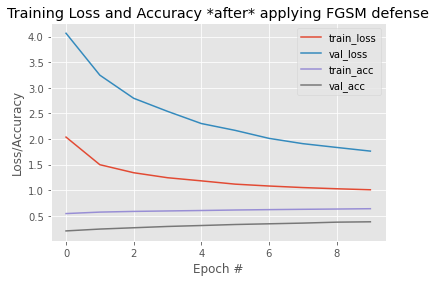

In [23]:
# plot the training loss and accuracy over time before applying defense
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy *after* applying FGSM defense")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()